### Notebook for simple decoding between concepts - 2x2 decoding (could add to axis)

In [25]:
from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from data_structures import PatientData
from decoders import ConceptDecoder, SingleResultsManager
from sklearn.svm import LinearSVC


In [6]:
def generate_consistent_combinations(strings_list, group_size):
    all_combos = list(combinations(strings_list, group_size))
    unique_pairs = []
    seen = set()
    
    for combo in all_combos:
        # Find the complement (the 4 items not in this combination)
        complement = tuple(c for c in strings_list if c not in combo)
        
        # order is alphabetic so we end up with duplicate (s1, s2), (s1, s2) instead of (s1, s2), (s2, s1)
        if combo < complement:
            pair = (combo, complement)
        else:
            pair = (complement, combo)

        pair_str = str(pair)  
        if pair_str not in seen:
            unique_pairs.append(pair)
            seen.add(pair_str)
    
    return unique_pairs

In [18]:
best_concepts = [
    "A.Fayed", 
    "J.Bauer", 
    "N.Yassir", 
    "K.Hayes", 
]
stable_groups = generate_consistent_combinations(best_concepts, 2)

In [19]:
stable_groups

[(('A.Fayed', 'J.Bauer'), ('N.Yassir', 'K.Hayes')),
 (('A.Fayed', 'N.Yassir'), ('J.Bauer', 'K.Hayes')),
 (('A.Fayed', 'K.Hayes'), ('J.Bauer', 'N.Yassir'))]

We expect Group 1: Fayed and Bauer vs Yassir and Hayes axis to represent gender

We expect Group 2: Fayed, Yassir vs Bauer, Hayes to represent race (white vs arab)

We expect Group 3: Fayed, Hayes vs Bauer, Yassir to not represent anything meaningful, expect worse decoding performance

In [20]:
p563 = PatientData(pid='563')

# Set a threshold for neuron filtering
THRESHOLD = 0.1  # firing rate threshold

p563_fr_neurons = p563.filter_neurons_by_fr(
    neurons=p563.neurons, 
    window=(p563.times_dict['movie_start_rel'], p563.times_dict['preSleep_recall_start_rel']), 
    threshold=THRESHOLD
)
p563_mtl_fr_neurons = p563.filter_mtl_neurons(neurons=p563_fr_neurons)

./Data/40m_act_24_S06E01_30fps_character_frames.csv


In [34]:
group_manager = SingleResultsManager(
    patient_data=p563,
    concept_items = stable_groups,
    epoch='movie',
    classifier=LinearSVC(),
    standardize=True,
    pseudo=True,  # Use pseudopopulations for balanced datasets
    neurons=p563_mtl_fr_neurons
)

In [37]:
num_iterations = 5
group_manager.run_decoding(num_iter=num_iterations)  


Decoding for 563: 100%|██████████| 3/3 [01:43<00:00, 34.62s/it]


In [26]:
def plot_dichotomy_performance_with_key(results_manager, dichotomy_list, metric='test_roc_auc', figsize=(15, 12), title_suffix=""):
    """
    Plots decoding performance for dichotomies (1-N) and adds a text key below
    mapping numbers to the actual group comparisons.

    Args:
        results_manager: A SingleResultsManager object that has run decoding
                         on the items in dichotomy_list.
        dichotomy_list: The list of group-vs-group tuples exactly as used
                        when running the results_manager. The order determines
                        the x-axis order (1-N).
        metric (str): The performance metric from DecodingResult to plot.
        figsize (tuple): Figure size for the *entire* plot (bars + text key).
        title_suffix (str): Optional text to append to the plot title.
    """
    if not results_manager.results:
        print("Error: results_manager has no results. Did you run run_decoding?")
        return None

    expected_num_dichotomies = len(dichotomy_list)
    print(f"Expecting {expected_num_dichotomies} dichotomies based on input list.")

    performance_means = []
    performance_stds = []
    dichotomy_labels_numeric = [str(i + 1) for i in range(expected_num_dichotomies)]
    key_strings = [] # To store formatted strings for the text key

    found_count = 0
    missing_keys_indices = []

    # --- Data Processing ---
    for i, dichotomy_key in enumerate(dichotomy_list):
        # Format the key string regardless of results being present
        group1, group2 = dichotomy_key
        group1_str = '+'.join(group1)
        group2_str = '+'.join(group2)
        key_strings.append(f"{i+1}: ({group1_str}) vs ({group2_str})")

        if dichotomy_key in results_manager.results:
            results_for_key = results_manager.results[dichotomy_key]
            if results_for_key:
                try:
                    values = [getattr(r, metric) for r in results_for_key]
                    performance_means.append(np.mean(values))
                    performance_stds.append(np.std(values))
                    found_count += 1
                except AttributeError:
                    print(f"Error: Metric '{metric}' not found for dichotomy {i+1}. Plotting NaN.")
                    performance_means.append(np.nan)
                    performance_stds.append(np.nan)
                except Exception as e:
                     print(f"Error processing results for dichotomy {i+1}: {e}")
                     performance_means.append(np.nan)
                     performance_stds.append(np.nan)
            else:
                performance_means.append(np.nan)
                performance_stds.append(np.nan)
                missing_keys_indices.append(i + 1)
        else:
            performance_means.append(np.nan)
            performance_stds.append(np.nan)
            missing_keys_indices.append(i + 1)

    print(f"Processed results for {found_count}/{expected_num_dichotomies} dichotomies.")
    if missing_keys_indices:
         print(f"Missing or empty results for dichotomies (numbered 1 to {expected_num_dichotomies}): {sorted(list(set(missing_keys_indices)))}")


    # --- Plotting ---
    fig = plt.figure(figsize=figsize)

    # Define grid: 2 rows, 1 column. Top plot (bars) taller than bottom (text).
    # Adjust height_ratios if needed (e.g., [4, 1] for more space for bars)
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

    # --- Top Subplot: Bar Chart ---
    ax_bar = fig.add_subplot(gs[0])

    x_positions = np.arange(expected_num_dichotomies)
    plot_stds = np.array(performance_stds)
    plot_stds[np.isnan(performance_means)] = 0 # Avoid error bars for NaN means

    ax_bar.bar(x_positions,
               np.nan_to_num(performance_means, nan=0.0),
               yerr=plot_stds,
               align='center',
               alpha=0.75,
               ecolor='black',
               capsize=4)

    ax_bar.set_ylabel(f'{metric.replace("_", " ").title()}')
    # Remove x-label from bar chart, it's implied by the key below
    ax_bar.set_xlabel('')
    ax_bar.set_xticks(x_positions)
    ax_bar.set_xticklabels(dichotomy_labels_numeric, rotation=90, fontsize=8)

    if "roc_auc" in metric.lower() or "accuracy" in metric.lower():
         ax_bar.set_ylim(0.0, 1.05)
         ax_bar.axhline(0.5, color='grey', linestyle='--', linewidth=0.8, label='Chance (0.5)')
         ax_bar.legend(loc='lower right')

    ax_bar.grid(axis='y', linestyle=':', linewidth=0.5) # Add horizontal grid lines

    # --- Bottom Subplot: Text Key ---
    ax_text = fig.add_subplot(gs[1])
    ax_text.axis('off') # Hide axes lines and ticks

    # Calculate positions for text lines
    num_lines = len(key_strings)
    # Split into two columns if too many lines
    if num_lines > 20: # Adjust this threshold as needed
        split_point = (num_lines + 1) // 2
        col1_strings = key_strings[:split_point]
        col2_strings = key_strings[split_point:]
        max_lines_per_col = split_point

        # Column 1
        y_start = 0.95
        y_step = 1.0 / (max_lines_per_col + 1) if max_lines_per_col > 0 else 1.0
        for i, line in enumerate(col1_strings):
            ax_text.text(0.01, y_start - i * y_step, line,
                         ha='left', va='top', fontsize=7, family='monospace')
        # Column 2
        for i, line in enumerate(col2_strings):
             ax_text.text(0.51, y_start - i * y_step, line,
                          ha='left', va='top', fontsize=7, family='monospace')

    else:
        # Single column
        y_start = 0.95
        y_step = 1.0 / (num_lines + 1) if num_lines > 0 else 1.0
        for i, line in enumerate(key_strings):
            ax_text.text(0.01, y_start - i * y_step, line,
                         ha='left', va='top', fontsize=9, family='monospace')


    # --- Overall Figure Title ---
    patient_id = results_manager.patient_data.pid
    epoch = results_manager.epoch
    base_title = f'Group Decoding Performance for {expected_num_dichotomies} Dichotomies'
    full_title = f'{base_title}\nPatient {patient_id}, Epoch: {epoch}'
    if title_suffix:
        full_title += f" - {title_suffix}"
    fig.suptitle(full_title, y=0.99) # Adjust y if title overlaps top plot

    # Adjust layout - rect might need tuning depending on title length
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()

    # Optionally return the processed data
    #return {'dichotomy_num': dichotomy_labels_numeric, 'mean_perf': performance_means, 'std_perf': performance_stds, 'key': key_strings}

Expecting 3 dichotomies based on input list.
Processed results for 3/3 dichotomies.


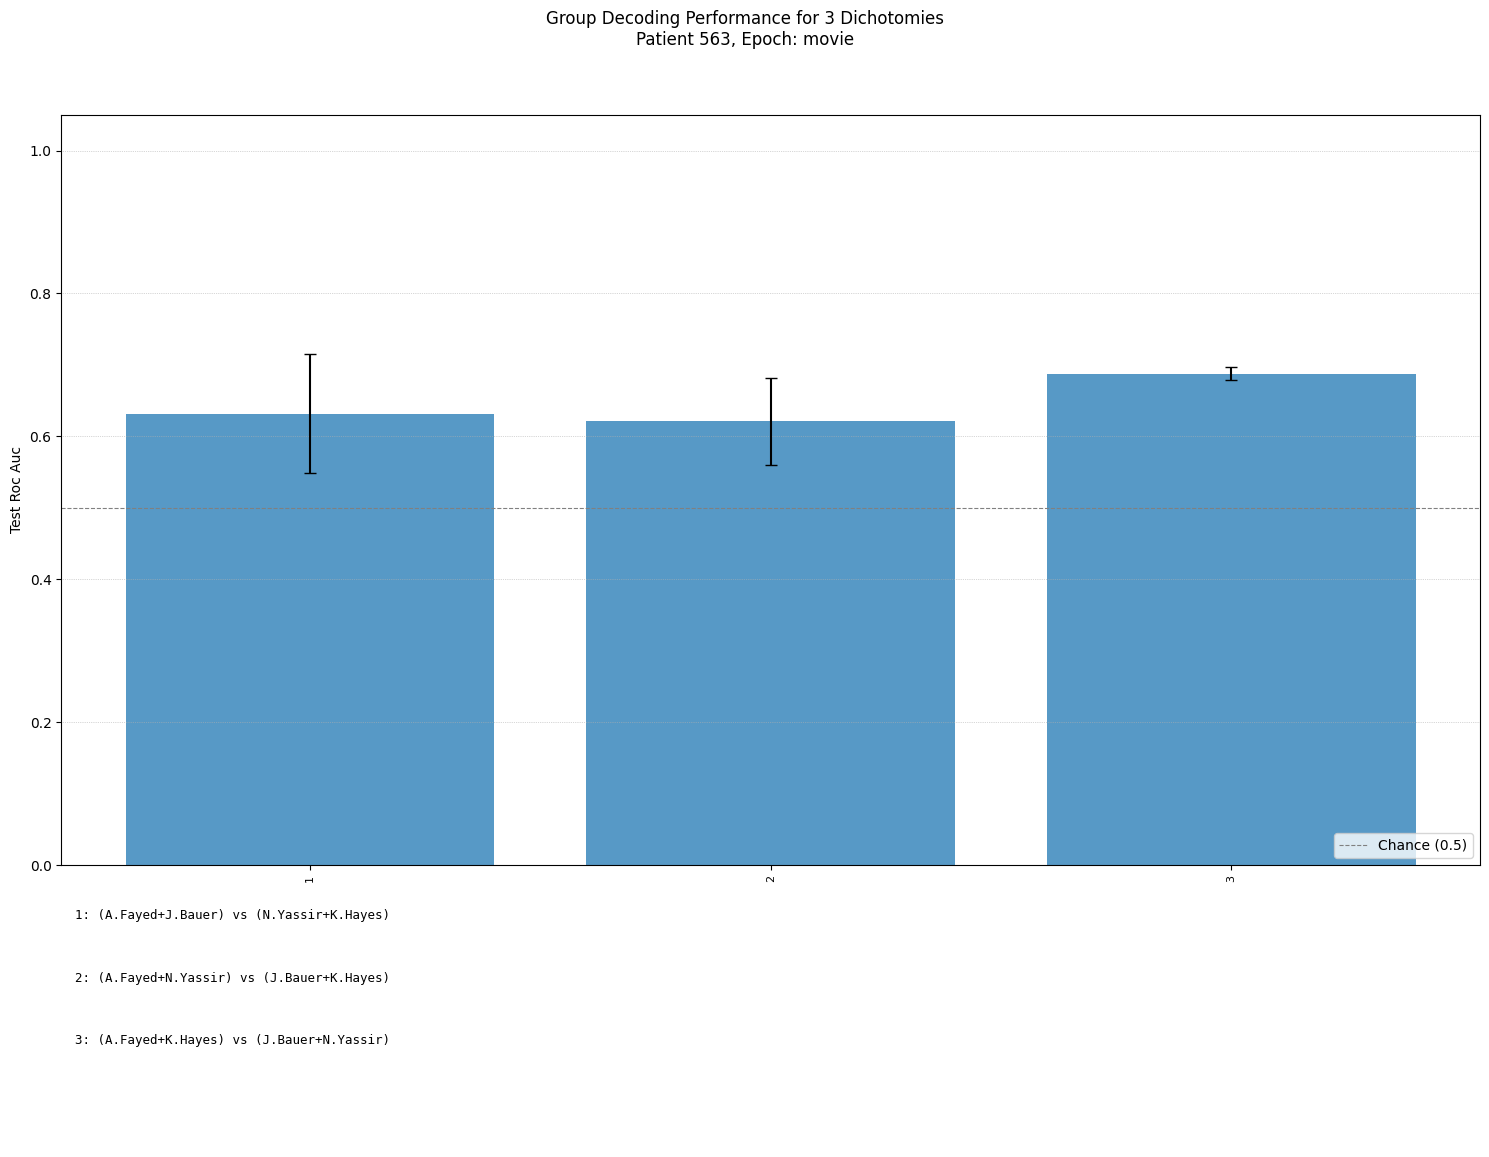

In [38]:
plot_dichotomy_performance_with_key(group_manager, stable_groups, metric='test_roc_auc')


In [47]:
group_manager.results[(('A.Fayed', 'J.Bauer'),
  ('N.Yassir',
   'K.Hayes'))][0]

DecodingResult(test_accuracy=0.6212121212121212, train_accuracy=0.845, test_roc_auc=np.float64(0.6212121212121212), train_roc_auc=np.float64(0.845), train_samples={'group1': np.int64(200), 'group2': np.int64(200), np.str_('N.Yassir'): np.int64(100), np.str_('A.Fayed'): np.int64(100), np.str_('K.Hayes'): np.int64(100), np.str_('J.Bauer'): np.int64(100)}, test_samples={'group1': np.int64(66), 'group2': np.int64(66), np.str_('N.Yassir'): np.int64(33), np.str_('A.Fayed'): np.int64(33), np.str_('K.Hayes'): np.int64(33), np.str_('J.Bauer'): np.int64(33)}, predictions=array([0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 

In [58]:
def visualize_decoding_result(decoding_result, pca_components=2, figsize=(16, 7), cmap='tab10', 
                              show_decision_boundary=True, alpha=0.7, s=60):
    """
    Visualize a DecodingResult object in PCA space with colored concepts.
    
    Parameters:
    -----------
    decoding_result : DecodingResult
        A DecodingResult object from ConceptDecoder
    pca_components : int, default=2
        Number of PCA components to use (2 or 3)
    figsize : tuple, default=(16, 7)
        Figure size (width, height) in inches
    cmap : str or colormap, default='tab10'
        Colormap to use for different concepts
    show_decision_boundary : bool, default=True
        Whether to show the decision boundary (line in 2D, plane in 3D)
    alpha : float, default=0.7
        Transparency of scatter points
    s : int, default=60
        Size of scatter points
        
    Returns:
    --------
    fig : matplotlib.pyplot.Figure
        The figure containing the visualization
    
    Notes:
    ------
    Marker shapes encode group membership:
    - Circles (o): Group 1 concepts
    - Triangles (^): Group 2 concepts
    
    Colors encode individual concepts within each group.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.decomposition import PCA
    import matplotlib.patches as mpatches
    from mpl_toolkits.mplot3d import Axes3D
    
    # Extract data from decoding result
    data_dict = decoding_result.data
    X_train = data_dict['X_train']
    X_test = data_dict['X_test']
    y_train = data_dict['y_train']
    y_test = data_dict['y_test']
    
    # Get concept identities if available
    concept_ids_train = data_dict.get('concept_ids_train', None)
    concept_ids_test = data_dict.get('concept_ids_test', None)
    
    # If concept IDs are not available, create dummy labels based on group (0 or 1)
    if concept_ids_train is None or concept_ids_test is None:
        print("Warning: Concept identities not found in data. Using binary group labels.")
        # Create placeholder concept IDs based on binary labels
        group1_name = "Group 1"
        group2_name = "Group 2"
        concept_ids_train = np.array([group1_name if label == 0 else group2_name for label in y_train])
        concept_ids_test = np.array([group1_name if label == 0 else group2_name for label in y_test])
    
    # Get unique concepts
    all_concepts = np.unique(np.concatenate([concept_ids_train, concept_ids_test]))
    n_concepts = len(all_concepts)
    
    # Create a dictionary mapping concepts to numeric indices for coloring
    concept_to_idx = {concept: i for i, concept in enumerate(all_concepts)}
    
    # Create numeric arrays for coloring based on concepts
    train_colors = np.array([concept_to_idx[concept] for concept in concept_ids_train])
    test_colors = np.array([concept_to_idx[concept] for concept in concept_ids_test])
    
    # Determine which group each concept belongs to
    concept_to_group = {}
    for concept, idx in zip(concept_ids_train, y_train):
        concept_to_group[concept] = idx
    
    # Create the colormap for concepts
    if isinstance(cmap, str):
        cmap = plt.get_cmap(cmap, n_concepts)
    
    # Set up the figure based on PCA components
    is_3d = (pca_components == 3)
    plt.ioff()  # Turn off interactive mode temporarily
    fig = plt.figure(figsize=figsize)
    
    if is_3d:
        ax_train = fig.add_subplot(121, projection='3d')
        ax_test = fig.add_subplot(122, projection='3d')
    else:
        ax_train = fig.add_subplot(121)
        ax_test = fig.add_subplot(122)
    
    # Fit PCA to all data to have consistent components
    all_X = np.vstack([X_train, X_test])
    pca = PCA(n_components=pca_components)
    pca.fit(all_X)
    
    # Transform the data
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    # Calculate explained variance
    var_ratios = pca.explained_variance_ratio_
    
    # Function to plot data in 2D or 3D
    def plot_data(ax, X_pca, colors, concepts, y_labels, title, is_3d=False):
        # Different markers for different groups
        marker_styles = ['o', '^']  # Circle for Group 1, Triangle for Group 2
        
        # Plot each concept separately with appropriate marker
        for i, concept in enumerate(all_concepts):
            # Find all points from this concept
            mask = np.array([c == concept for c in concepts])
            if np.any(mask):
                # Get the group for this concept
                group = concept_to_group.get(concept, 0)
                
                # Get marker style based on group
                marker = marker_styles[int(group)]
                
                # Plot with the correct color and marker
                color = cmap(i)
                
                if is_3d:
                    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], X_pca[mask, 2],
                              color=color, marker=marker, 
                              alpha=alpha, s=s, label=f"{concept} (Group {int(group)+1})")
                else:
                    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                              color=color, marker=marker, 
                              alpha=alpha, s=s, label=f"{concept} (Group {int(group)+1})")
        
        # Add decision boundary if requested
        if show_decision_boundary and hasattr(decoding_result.classifier, 'coef_'):
            w = decoding_result.classifier.coef_[0]
            b = decoding_result.classifier.intercept_[0]
            
            # Project the coefficients to PCA space
            w_pca = pca.components_[:pca_components, :] @ w
            
            if is_3d:
                # Create a grid for visualization
                x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
                y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
                
                # Create a meshgrid for the decision plane
                xx, yy = np.meshgrid(np.linspace(x_min, x_max, 10),
                                     np.linspace(y_min, y_max, 10))
                
                # Calculate z values: w[0]*x + w[1]*y + w[2]*z + b = 0
                # So z = (-w[0]*x - w[1]*y - b) / w[2]
                if abs(w_pca[2]) > 1e-10:  # Avoid division by zero
                    zz = (-w_pca[0] * xx - w_pca[1] * yy - b) / w_pca[2]
                    
                    # Plot the surface with a slight transparency
                    plane = ax.plot_surface(xx, yy, zz, alpha=0.2, color='gray')
                else:
                    # The plane is perpendicular to the x-y plane
                    # We'll show a vertical plane instead
                    if abs(w_pca[0]) > 1e-10:
                        xx = (-w_pca[1] * yy - b) / w_pca[0]
                        zz = np.linspace(X_pca[:, 2].min() - 1, X_pca[:, 2].max() + 1, 10)
                        xx, zz = np.meshgrid(xx[0, :], zz)
                        yy_plane = np.tile(yy[:, 0].reshape(-1, 1), (1, 10))
                        ax.plot_surface(xx, yy_plane, zz, alpha=0.2, color='gray')
                    elif abs(w_pca[1]) > 1e-10:
                        yy = (-w_pca[0] * xx - b) / w_pca[1]
                        zz = np.linspace(X_pca[:, 2].min() - 1, X_pca[:, 2].max() + 1, 10)
                        yy, zz = np.meshgrid(yy[0, :], zz)
                        xx_plane = np.tile(xx[:, 0].reshape(-1, 1), (1, 10))
                        ax.plot_surface(xx_plane, yy, zz, alpha=0.2, color='gray')
            else:
                # 2D decision boundary
                x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
                
                # Calculate corresponding y values: w[0]*x + w[1]*y + b = 0
                if abs(w_pca[1]) > 1e-10:  # Avoid division by zero
                    y_min = (-w_pca[0] * x_min - b) / w_pca[1]
                    y_max = (-w_pca[0] * x_max - b) / w_pca[1]
                    ax.plot([x_min, x_max], [y_min, y_max], 'k-', alpha=0.5)
                else:
                    # Vertical line case
                    boundary_x = -b / w_pca[0]
                    y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
                    ax.plot([boundary_x, boundary_x], [y_min, y_max], 'k-', alpha=0.5)
        
        # Add axis labels
        if is_3d:
            ax.set_xlabel(f'PC1 ({var_ratios[0]:.1%})')
            ax.set_ylabel(f'PC2 ({var_ratios[1]:.1%})')
            ax.set_zlabel(f'PC3 ({var_ratios[2]:.1%})')
        else:
            ax.set_xlabel(f'PC1 ({var_ratios[0]:.1%})')
            ax.set_ylabel(f'PC2 ({var_ratios[1]:.1%})')
        
        ax.set_title(title)
        
    # Plot training data
    plot_data(ax_train, X_train_pca, train_colors, concept_ids_train, y_train,
              f'Training Data (Acc: {decoding_result.train_accuracy:.3f})', is_3d=is_3d)
    
    # Plot testing data
    plot_data(ax_test, X_test_pca, test_colors, concept_ids_test, y_test, 
              f'Testing Data (Acc: {decoding_result.test_accuracy:.3f})', is_3d=is_3d)
    
    # Create legend with colored patches for each concept and group
    legend_handles = []
    
    # Create a custom legend
    for concept in all_concepts:
        color = cmap(concept_to_idx[concept])
        group = concept_to_group.get(concept, 0)
        marker = 'o' if group == 0 else '^'
        
        # Create a line with marker for the legend (better than just patches)
        from matplotlib.lines import Line2D
        handle = Line2D([0], [0], marker=marker, color='w', markerfacecolor=color,
                       markersize=10, label=f"{concept} (Group {int(group)+1})")
        legend_handles.append(handle)
    
    # Add legend outside the plots
    fig.legend(handles=legend_handles, loc='lower center', 
               bbox_to_anchor=(0.5, 0), ncol=min(5, n_concepts))
    
    # Add a title with performance metrics
    plt.suptitle(f"Concept Decoding Visualization\n"
                f"Train Acc: {decoding_result.train_accuracy:.3f}, "
                f"Test Acc: {decoding_result.test_accuracy:.3f}, "
                f"AUC: {decoding_result.test_roc_auc:.3f}",
                fontsize=14)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)  # Make room for the legend
    
    # Turn interactive mode back on
    plt.ion()
    
    return fig

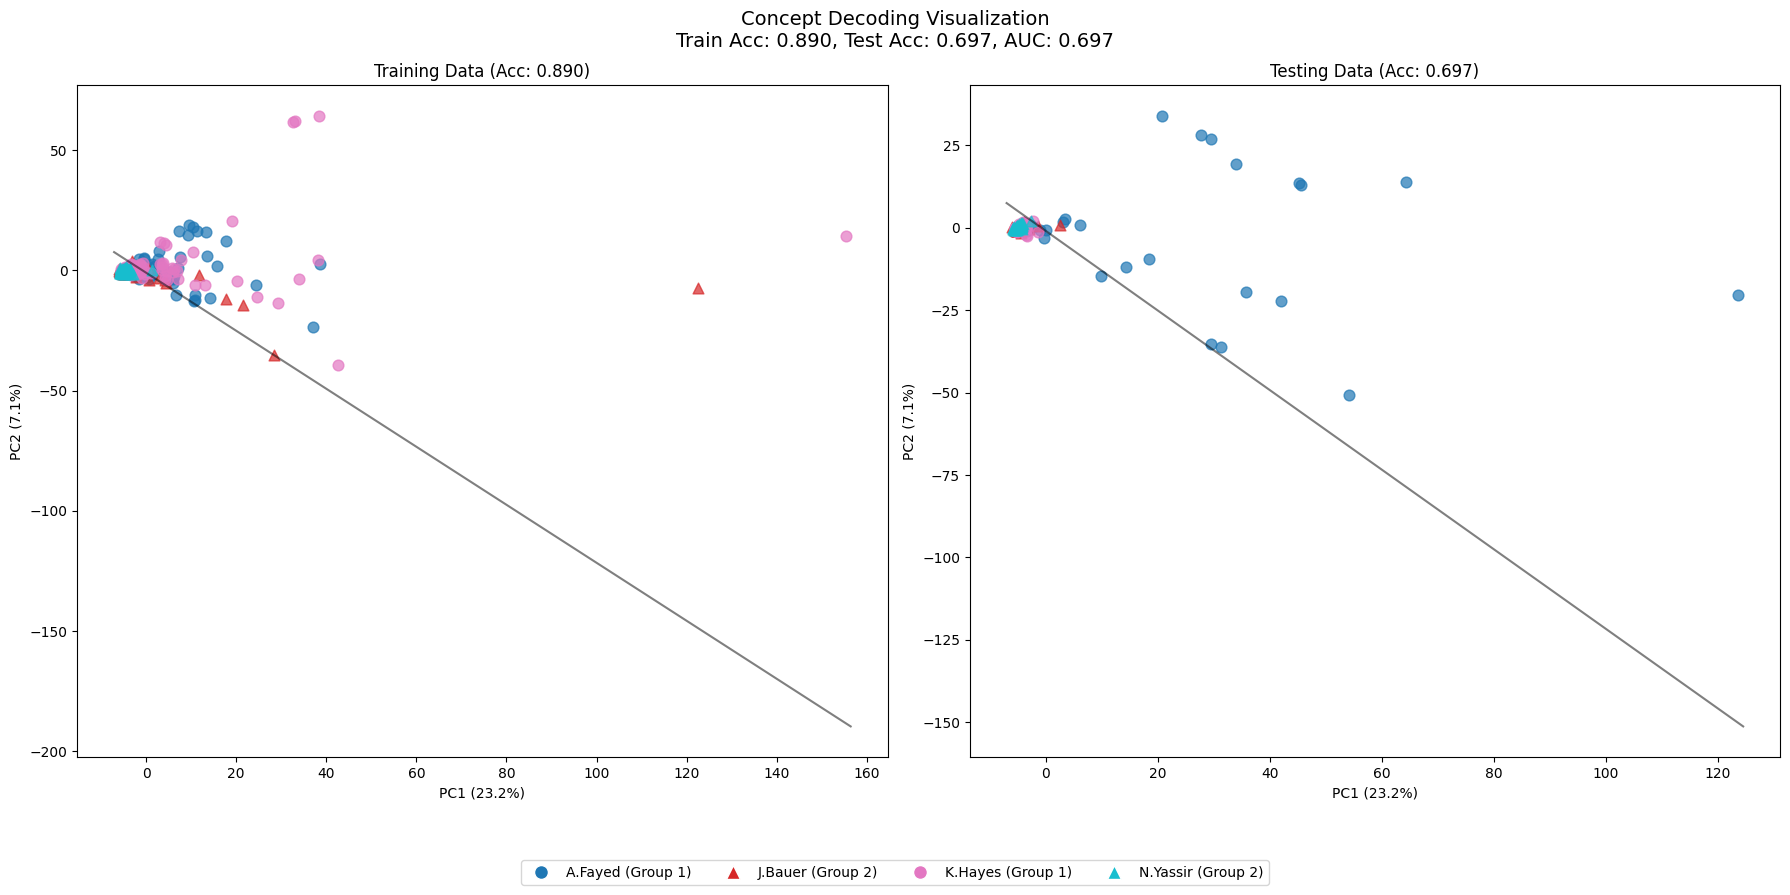

In [63]:
result = group_manager.results[(('A.Fayed', 'K.Hayes'), ('J.Bauer', 'N.Yassir'))][1]
#fig = visualize_decoding_result(result)
visualize_decoding_result(result, pca_components=2, figsize=(18, 9))

